In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scVI
import tensorflow as tf

from helper import *
from benchmarking import *
% matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
data_path = "/home/ubuntu/single-cell-scVI/data/Klein/"

# import and format

In [3]:
X = pd.read_csv(data_path + "bBM.raw_umifm_counts.csv")
X.index = X["cell_id"]
print X.shape
# remove this library to avoid dealing with batch effects
X.drop(X.index[X["library_id"] == "basal_bm1"], inplace=True)
print X.shape

(5432, 28210)
(4592, 28210)


In [4]:
Y = pd.read_csv(data_path + "bBM.spring_and_pba.csv")
Y.index = Y["cell_id"]
gene_filter_list = np.loadtxt(data_path + "bBM.filtered_gene_list.paper.txt", dtype=np.str)
data = X.merge(Y, how="inner")
expression_data = data[gene_filter_list]
layout = data[["x_spring", "y_spring"]]
meta = data[["Potential", "Pr_Er", "Pr_Gr", "Pr_Ly", "Pr_DC", "Pr_Mk", "Pr_Mo", "Pr_Ba"]]
expression_data = expression_data.as_matrix()
layout = layout.as_matrix()

In [ ]:
Z = pd.read_csv(data_path + "bBM.filtered_normalized_counts.csv")
Z.index = Z["cell_id"]
Z.drop(Z.index[Z["library_id"] == "basal_bm1"], inplace=True)
gene_filter_list = np.loadtxt(data_path + "bBM.filtered_gene_list.paper.txt", dtype=np.str)
Y = pd.read_csv(data_path + "bBM.spring_and_pba.csv")
Y.index = Y["cell_id"]
data = Z.merge(Y, how="inner")
expression_data = data[gene_filter_list]
layout = data[["x_spring", "y_spring"]]
meta = data[["Potential", "Pr_Er", "Pr_Gr", "Pr_Ly", "Pr_DC", "Pr_Mk", "Pr_Mo", "Pr_Ba"]]
expression_data = expression_data.as_matrix()
layout = layout.as_matrix()

In [5]:
print expression_data.shape[0], " cells with ", expression_data.shape[1], " genes"

4016  cells with  7397  genes


In [ ]:
X_zero, i, j, ix = dropout(expression_data, rate=0.2)
np.save(data_path + "imputation/X_zero.npy", X_zero)
np.save(data_path + "imputation/i.npy", i)
np.save(data_path + "imputation/j.npy", j)
np.save(data_path + "imputation/ix.npy", ix)

In [7]:
np.mean(X_zero == expression_data), np.mean(X_zero == 0), np.mean(expression_data == 0)

(0.94218616947648104, 0.91389457715979394, 0.86370773496523567)

In [8]:
X_zero, i, j, ix = \
        np.load(data_path + "imputation/X_zero.npy"), np.load(data_path + "imputation/i.npy"),\
        np.load(data_path + "imputation/j.npy"), np.load(data_path + "imputation/ix.npy")

In [9]:
mean_MAGIC = np.load(data_path + "imputation/X_zero_MAGIC.npy")
print("MAGIC", imputation_error(mean_MAGIC, expression_data, X_zero, i, j, ix))

('MAGIC', 0.58781481229829469)


In [7]:
log_library_size = np.log(np.sum(expression_data, axis=1))
zero_amount = np.sum(expression_data == 0, axis=1)
mean, var = np.mean(log_library_size), np.var(log_library_size)

In [8]:
learning_rate = 0.0004
epsilon = 0.01

tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, expression_data.shape[1]), name='x')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                         optimize_algo=optimizer, phase=training_phase, \
                          library_size_mean=mean, library_size_var=var, n_latent=10)

# Session creation
sess = tf.Session()

Running scVI on 7397 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
1 hidden layers at 128 each for a final 10 latent space


In [9]:
sess.run(tf.global_variables_initializer())
train_model(model, (expression_data, expression_data), sess, 120)

{'dispersion': 'gene',
 'dropout_nn': 0.1,
 'epoch': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119],
 'model': 'scVIModel',
 'n_hidden': 128,
 'n_input': 7397,
 'n_layers': 1,
 't_loss': [14872.563,
  13387.278,
  11572.312,
  8442.9121,
  7601.3999,
  6855.7549,
  5505.4219,
  5442.6611,
  4690.769,
  4766.4048,
  3

In [9]:
meta.head()

,Potential,Pr_Er,Pr_Gr,Pr_Ly,Pr_DC,Pr_Mk,Pr_Mo,Pr_Ba
0,16.478,4.838100e-07,0.99999,6.165000e-07,0.000006,7.316800e-08,0.000003,2.895200e-07
1,20.014,7.798200e-04,0.97960,1.192900e-03,0.012171,1.097700e-04,0.005926,2.229200e-04
2,19.501,3.258200e-04,0.99471,5.407800e-04,0.002864,3.707600e-05,0.001452,7.155600e-05
3,20.514,4.636700e-03,0.95515,4.485400e-03,0.019768,4.857800e-04,0.014610,8.653300e-04
4,18.693,5.134800e-05,0.99885,1.868000e-04,0.000635,6.945500e-06,0.000255,1.507100e-05


In [14]:
sess.run(tf.global_variables_initializer())
res = train_model(model, (X_zero, expression_data), sess, 200)
eval_imputed_data(model, (X_zero, i, j, ix), expression_data, sess)

0.82543376088142395

In [10]:
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph
import networkx as nx

def show_viz(latent, name, algo=None, labels=None, clusters_cmap=7, cmap="tab10"):
    
    if clusters_cmap == 0:
        cmap = plt.get_cmap(cmap)
    else:
        cmap = plt.get_cmap(cmap, clusters_cmap)
        
    if labels is None:
        labels = c_train
        
    if algo == "tSNE":
        layout = TSNE().fit_transform(latent)
    elif algo == "kNN":
        ad = kneighbors_graph(latent, 10, include_self=False)
        graph = nx.from_scipy_sparse_matrix(ad)
        lag_node = 0.9
        pos = nx.spring_layout(graph, k=np.sqrt(1.0/(lag_node*ad.shape[0])), iterations=200)
        layout =  np.concatenate([x[:, np.newaxis] for x in pos.values()], axis=1).T   
    else:
        layout = latent
        
        
    plt.figure(figsize=(5, 5))
    cax = plt.scatter(layout[:, 0], layout[:, 1], c=labels, \
                                   cmap=cmap, edgecolors='none')
    plt.axis("off")
    if algo is None:
        st = "tSNE"
    else:
        st = algo
    plt.tight_layout()

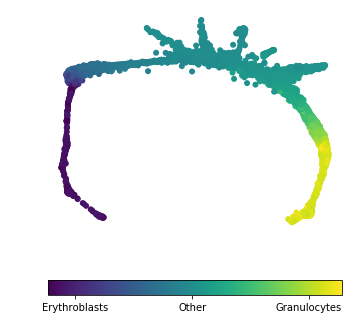

In [11]:
def logit(p):
    p = np.copy(p.as_matrix())
    p[p == 0] = np.min(p[p > 0])
    p[p == 1] = np.max(p[p < 1])
    return np.log(p / (1-p))
show_viz(layout, "PBA", algo=None, labels=logit(meta.iloc[:, 2]) - logit(meta.iloc[:, 1]), \
             clusters_cmap=0, cmap="viridis")
cbar = plt.colorbar(ticks=[-40, 0, 40], orientation='horizontal')
cbar.ax.set_xticklabels(['Erythroblasts', 'Other', 'Granulocytes'])  # horizontal colorbar
plt.savefig("PBA_scale.pdf", transparency=True)

In [12]:
from R_interop import SIMLR
from sklearn.decomposition import PCA

In [72]:
simlr = SIMLR(n_clusters=10)
%time simlr.estimate_clusters_numbers(expression_data)

CPU times: user 14min 33s, sys: 1min 7s, total: 15min 40s
Wall time: 16min 51s


In [73]:
simlr.estimated_clusters
# SIMLR find 5 clusters with two different heuristics

R object with classes: ('list',) mapped to:
<ListVector - Python:0x7ff4c5766710 / R:0x2c6d1b18>
[FloatVector, FloatVector]
  K1: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7ff4c5763248 / R:0x2c62a480>
[370.738729, 2461.998349, -5091.359186, 4519.988138, -1008.237382, -2606.308548]
  K2: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7ff4c8671f80 / R:0x2c62a4e8>
[494.318305, 3077.497937, -6109.631023, 5273.319494, -1152.271293, -2932.097116]

In [13]:
simlr = SIMLR.SIMLR(n_clusters=5)
%time simlr.fit_transform(expression_data)

Performing fast PCA.
Performing k-nearest neighbour search.
Computing the multiple Kernels.
Performing the iterative procedure  5  times.
Iteration:  1 
Iteration:  2 
Iteration:  3 
Iteration:  4 
Iteration:  5 
Performing Kmeans.
Performing t-SNE.
The main loop will be now performed with a maximum of 300 iterations.
Performing iteration 1.
Performing iteration 2.
Performing iteration 3.
Performing iteration 4.
Performing iteration 5.
Performing iteration 6.
Performing iteration 7.
Performing iteration 8.
Performing iteration 9.
Performing iteration 10.
Performing iteration 11.
Performing iteration 12.
Performing iteration 13.
Performing iteration 14.
Performing iteration 15.
Performing iteration 16.
Performing iteration 17.
Performing iteration 18.
Performing iteration 19.
Performing iteration 20.
Performing iteration 21.
Performing iteration 22.
Performing iteration 23.
Performing iteration 24.
Performing iteration 25.
Performing iteration 26.
Performing iteration 27.
Performing ite

SIMLR(n_clusters=5)

In [56]:
latent_pc = PCA(n_components=100).fit_transform(np.log(1 + expression_data))

In [14]:
latent_scVI = eval_latent(model, expression_data, sess)

## Latent Space tSNE

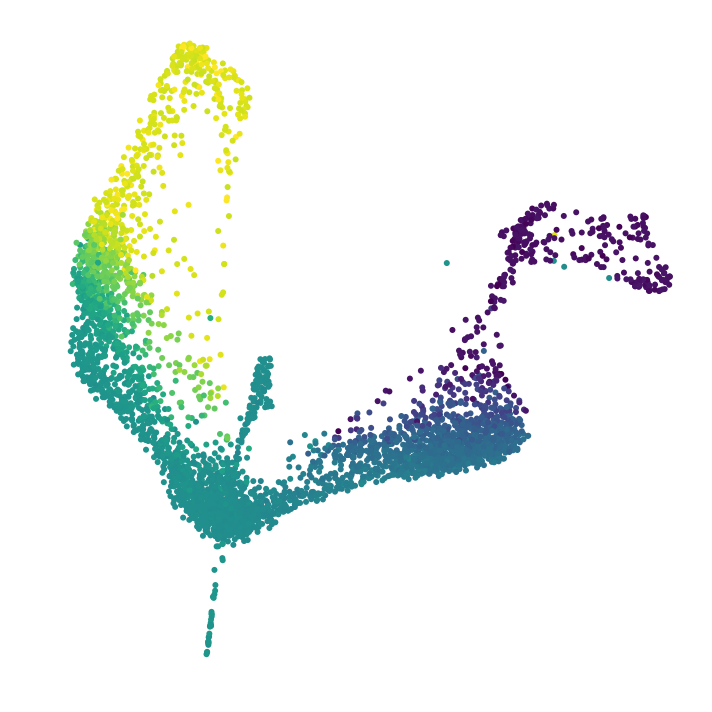

In [63]:
show_viz(latent_pc, \
          "PCA100", algo="kNN", labels=logit(meta.iloc[:, 2]) - logit(meta.iloc[:, 1]), \
         clusters_cmap=0, cmap="viridis")
plt.savefig("PCA_klein_kNN.pdf", dpi=300)

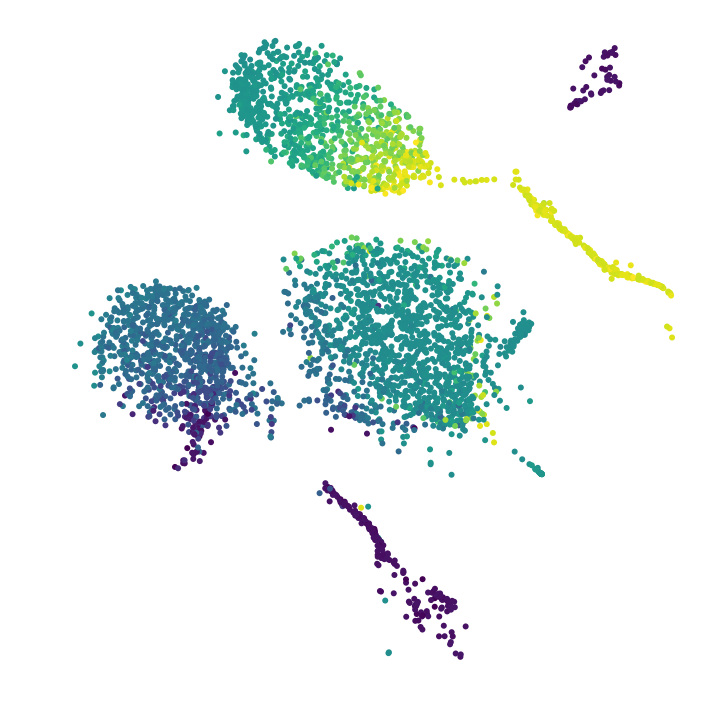

In [76]:
show_viz(simlr.ydata, "SIMLR", algo=None, labels=logit(meta.iloc[:, 2]) - logit(meta.iloc[:, 1]), \
         clusters_cmap=0, cmap="viridis")
plt.savefig("SIMLR_klein_tSNE.pdf", dpi=300)

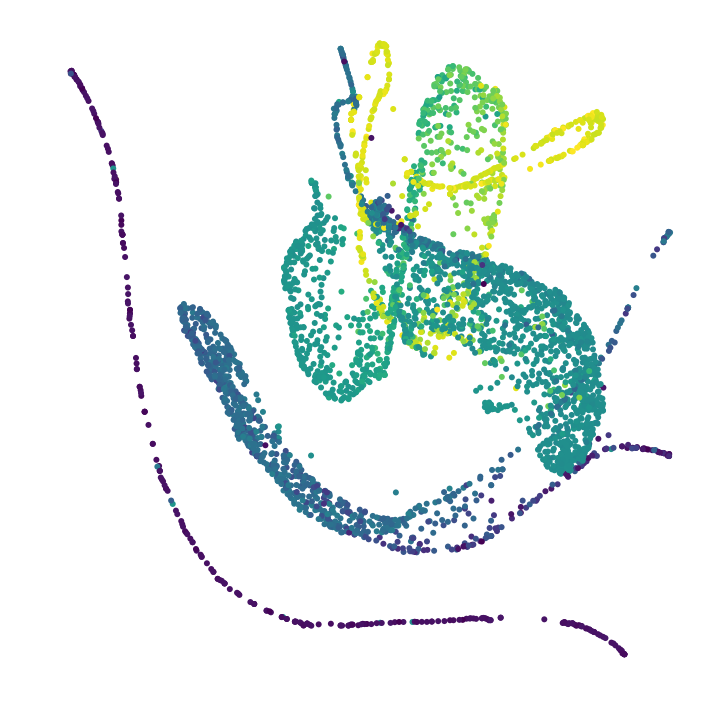

In [77]:
show_viz(simlr.F, "SIMLR", algo="kNN", labels=logit(meta.iloc[:, 2]) - logit(meta.iloc[:, 1]), \
         clusters_cmap=0, cmap="viridis")
plt.savefig("SIMLR_klein_kNN.pdf", dpi=300)

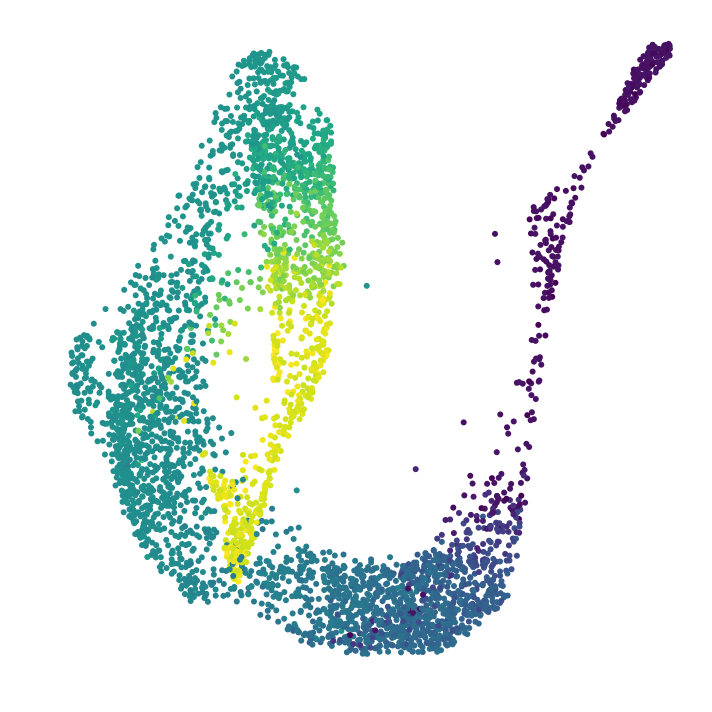

In [84]:
show_viz(latent_scVI, "scVI10", algo="kNN", labels = logit(meta.iloc[:, 2]) - logit(meta.iloc[:, 1]), \
         clusters_cmap=0, cmap="viridis")
plt.savefig("scVI_klein_kNN.pdf", dpi=300)

# distance matrix

In [100]:
pca = PCA(n_components=10)
% time latent_pc10 = pca.fit_transform(np.log(1 + expression_data))

CPU times: user 4.68 s, sys: 6.52 s, total: 11.2 s
Wall time: 1.92 s


In [15]:
from matplotlib import gridspec
def visualize_distance(latent, labels, algorithm):
    order_latent = np.vstack([x for _, x in sorted(zip(labels,latent), key=lambda pair: pair[0])])
    order_label = np.vstack([y for y, x in sorted(zip(labels,latent), key=lambda pair: pair[0])])
    distance = scipy.spatial.distance_matrix(order_latent, order_latent)  
    
    fig = plt.figure(figsize=(5, 5)) 
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 70], height_ratios=[1, 70])
    gs.update(wspace=0.05, hspace=0.05)
    ax0 = plt.subplot(gs[1])
    ax0.imshow(order_label.T, cmap='viridis', interpolation='none', aspect=100)
    ax0.axis('off')
    ax1 = plt.subplot(gs[3], sharex=ax0)
    dis= ax1.imshow(distance, cmap='hot', interpolation='none')
    fig.colorbar(dis, ax=ax1)
    ax1.axis('off')
    ax2 = plt.subplot(gs[2], sharey=ax1)
    ax2.imshow(order_label, cmap='viridis', interpolation='none', aspect=1/100.)
    ax2.axis('off')
    #plt.tight_layout()
    #fig.suptitle("Cell-Cell Similarity matrix on the "+ algorithm + " latent space", fontsize=16, y=0.92)

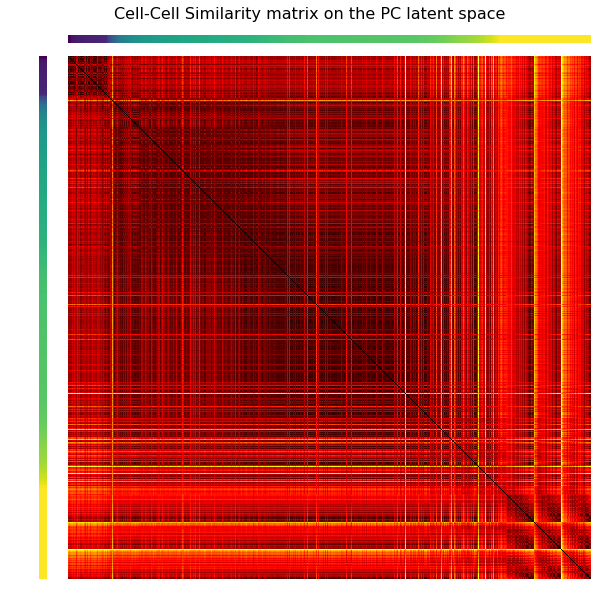

In [103]:
visualize_distance(latent_pc, logit(meta.iloc[:, 2]), "PC")
plt.savefig("PCA_klein_distance.pdf")

In [ ]:
visualize_distance(simlr.F, logit(meta.iloc[:, 2]), "SIMLR")
plt.savefig("SIMLR_klein_distance.pdf", dpi=300)

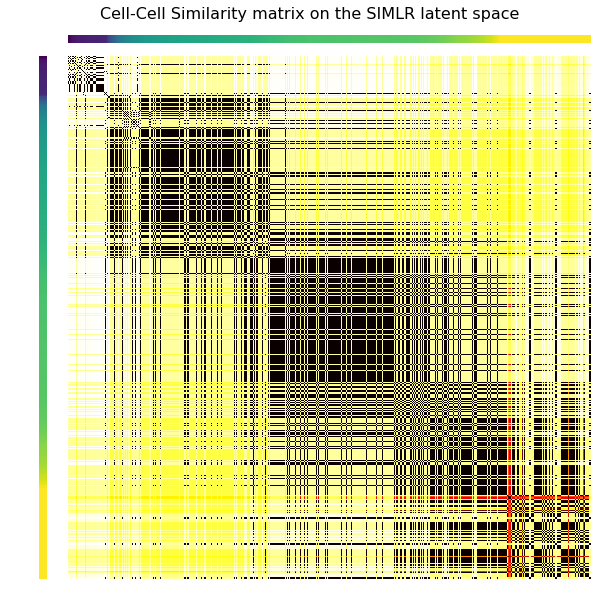

In [107]:
visualize_distance(simlr.F, logit(meta.iloc[:, 2]), "SIMLR")
plt.savefig("SIMLR_klein_distance.pdf", dpi=300)

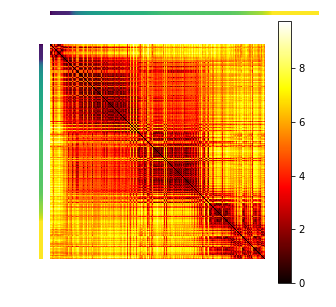

In [17]:
visualize_distance(latent_scVI, logit(meta.iloc[:, 2]), "scVI")
plt.savefig("scVI_klein_distance.pdf", dpi=300)

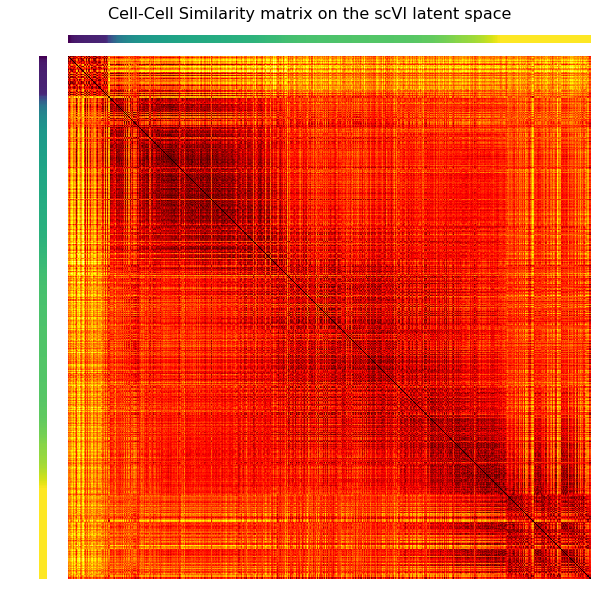

In [106]:
visualize_distance(latent_scVI, logit(meta.iloc[:, 2]), "scVI")
plt.savefig("scVI_klein_distance.pdf")

# Imputation